<a href="https://colab.research.google.com/github/LUNA-HYUN/HelmetDetectionV0/blob/main/HelmetDetectionV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>> [1. Setup] 필수 라이브러리 설치 및 환경 설정 중...
✅ 사용 장치(Device): Tesla T4

>> [2. Data] 데이터셋 다운로드 및 무결성 검사...
Using Colab cache for faster access to the 'hardhat-vest-dataset-v3' dataset.
📂 데이터셋 저장 경로: /kaggle/input/hardhat-vest-dataset-v3

📂 폴더 구조:
   📁 hardhat-vest-dataset-v3/
      📁 labels/: 1개 파일
         📁 val/: 2438개 파일
         📁 test/: 2455개 파일
         📁 train/: 17248개 파일
      📁 images/: 0개 파일
         📁 val/: 2438개 파일
         📁 test/: 2455개 파일
         📁 train/: 17248개 파일

📊 [데이터셋 통계 - 이미지 수량]
   - Train Set: 17248장
   - Valid Set: 2438장
   - Test Set: 2455장
   👉 총 이미지 수: 22141장

📊 [데이터셋 통계 - 클래스 분포]
        Count
Head    98256
Helmet  43905
Vest     6326
   👉 Head(2)와 Helmet(0) 데이터가 풍부함 확인됨.

>> [Class Distribution] 클래스별 객체 수 분포 시각화...


/tmp/ipython-input-1091203317.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_stats.index, y='Count', data=df_stats, palette='viridis')


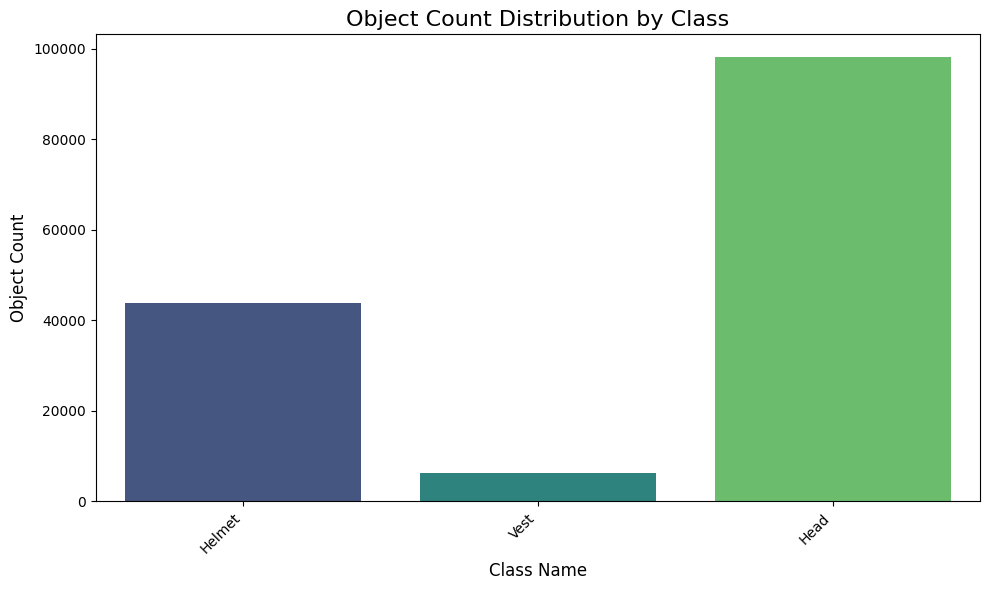

✅ 클래스별 객체 수 분포 시각화 완료.

📊 [데이터셋 통계 - 바운딩 박스 정보 추출 및 분석]
✅ 총 148487개의 바운딩 박스 데이터 추출 완료.

👉 바운딩 박스 데이터의 상위 5개 행:
   image_name  class_id class_name        cx        cy         w         h
0  a01944.jpg         0     Helmet  0.708594  0.348438  0.123438  0.237500
1  a01944.jpg         0     Helmet  0.834375  0.349219  0.146875  0.220312
2  a01944.jpg         1       Vest  0.850000  0.730469  0.196875  0.539062
3  a01944.jpg         1       Vest  0.663281  0.721094  0.185938  0.514062
4  a02327.jpg         0     Helmet  0.373437  0.565625  0.037500  0.078125

>> [Bounding Box Analysis] 바운딩 박스 중심 좌표(cx, cy) 분포 시각화...


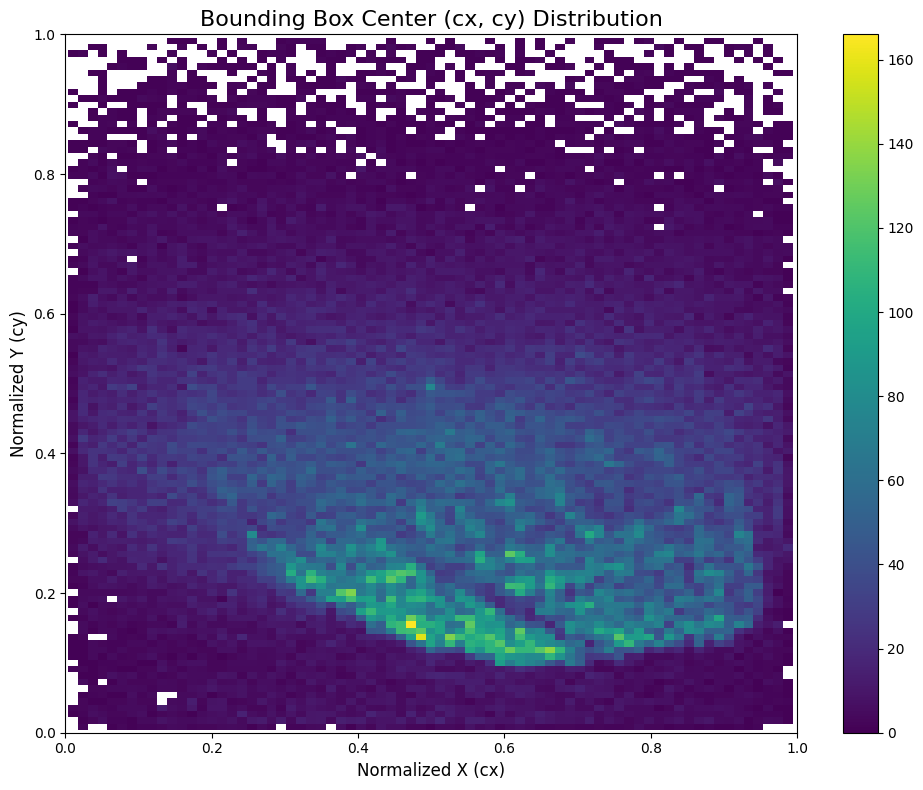

✅ 바운딩 박스 중심 좌표 분포 시각화 완료.

>> [Bounding Box Analysis] 바운딩 박스 크기(w, h) 분포 시각화...


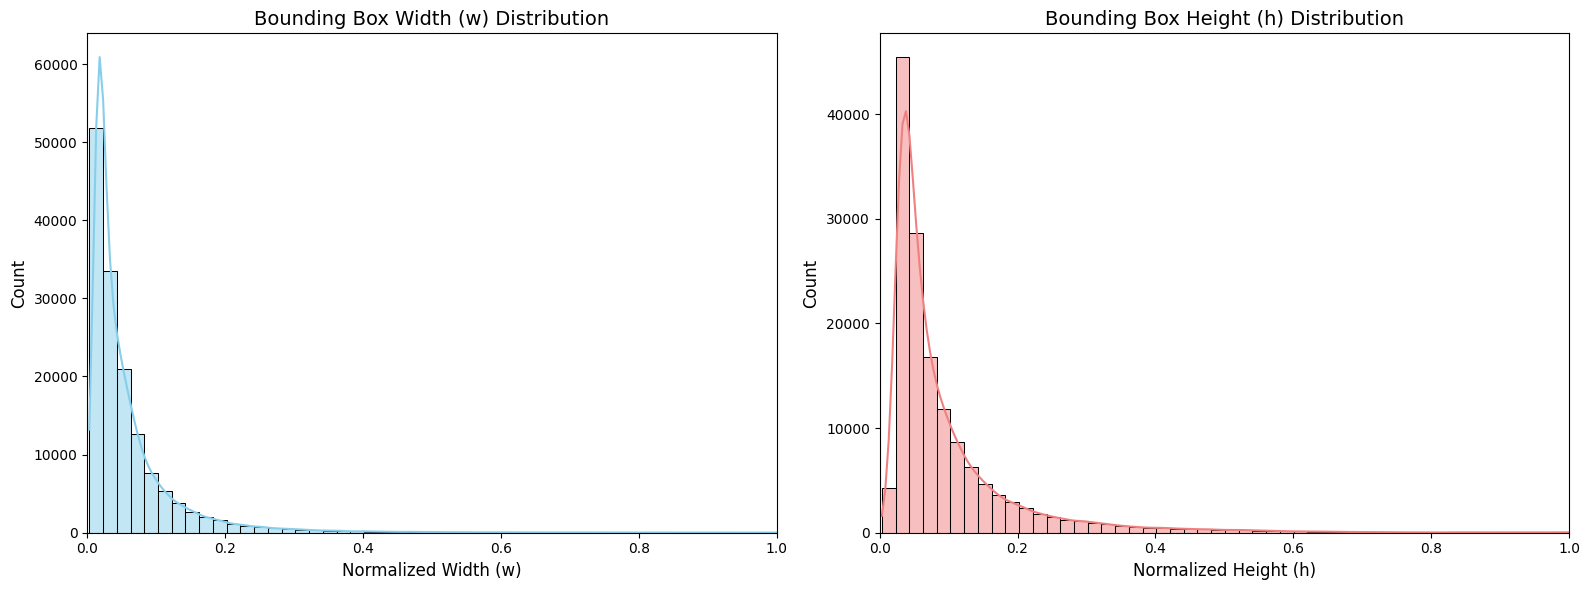

✅ 바운딩 박스 크기 분포 시각화 완료.

>> [Co-occurrence Analysis] 'Head'와 'Helmet' 동시 출현 분석 및 시각화...

👉 'Head' 및 'Helmet' 동시 출현 통계:
                               Category  Count
0             Total Images with Head(2)   5810
1           Total Images with Helmet(0)  12333
2  Images with both Head(2) & Helmet(0)   1528
3  Images with Head(2) only (No Helmet)   4282

👉 Head(2)가 존재하는 이미지 중 Helmet(0) 착용 비율:
                   Category     Ratio
0    Head(2) with Helmet(0)  0.262995
1  Head(2) only (No Helmet)  0.737005


/tmp/ipython-input-1091203317.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Ratio', data=ratio_data, palette='coolwarm')


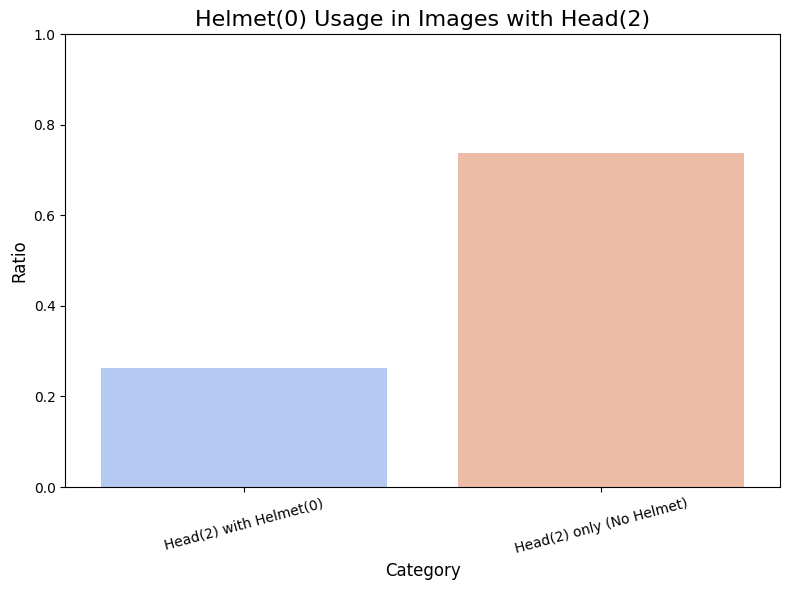

✅ 'Head'와 'Helmet' 동시 출현 분석 및 시각화 완료.

>> [3. Config] 학습 설정 파일(data.yaml) 생성...
✅ 설정 파일 생성 완료: /content/safety_data.yaml


In [ ]:
'''본 코드는 Google Colab에서 GPU를 사용해 실행한다는 가정하에 작성했습니다.'''

# ==================================================================================
# 1. 환경 설정 및 데이터 준비 (Environment Setup & Data Preparation)
# ==================================================================================
print(">> [1. Setup] 필수 라이브러리 설치 및 환경 설정 중...")
!pip install ultralytics kagglehub -q

import os
import glob
import yaml
import cv2
import torch
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from ultralytics import YOLO
from IPython.display import Image, display

# 하드웨어 가속(GPU) 설정 확인
DEVICE = 0 if torch.cuda.is_available() else 'cpu'
print(f"✅ 사용 장치(Device): {torch.cuda.get_device_name(0) if DEVICE == 0 else 'CPU'}")

# ----------------------------------------------------------------------------------
# 2. 데이터셋 다운로드 및 상세 분석 (Dataset Analysis)
# ----------------------------------------------------------------------------------
print("\n>> [2. Data] 데이터셋 다운로드 및 무결성 검사...")
try:
    dataset_path = kagglehub.dataset_download("muhammetzahitaydn/hardhat-vest-dataset-v3")
    print(f"📂 데이터셋 저장 경로: {dataset_path}")
except Exception as e:
    print(f"❌ 다운로드 실패: {e}")

# 폴더 구조 자동 탐색
images_root = os.path.join(dataset_path, 'images')
if not os.path.exists(images_root): images_root = dataset_path

subdirs = os.listdir(images_root)
train_dir = next((d for d in subdirs if 'train' in d), None)
val_dir = next((d for d in ['valid', 'val', 'validation'] if d in subdirs), None)
test_dir = next((d for d in subdirs if 'test' in d), None)

# [상세 정보 0] 폴더 구조 표시
print("\n📂 폴더 구조:")
def print_folder_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 3 * (level)
        if level == 0:
            print(f"   📁 {os.path.basename(root)}/") # 기본 폴더 이름
        else:
            # 현재 디렉토리의 파일 수 계산
            file_count = len(files)
            dir_name = os.path.basename(root)
            if dir_name:
                print(f"{indent}   📁 {dir_name}/: {file_count}개 파일")

    # 데이터셋 경로의 루트에 있는 파일 처리 (예: README 또는 data.yaml)
    root_files = [f for f in os.listdir(startpath) if os.path.isfile(os.path.join(startpath, f))]
    if root_files:
        print(' ' * 3)
        for f in root_files:
            print(f"   📄 {f}")

print_folder_structure(dataset_path)

# [상세 정보 1] 이미지 수 확인
print("\n📊 [데이터셋 통계 - 이미지 수량]")
data_dirs = {'Train': train_dir, 'Valid': val_dir, 'Test': test_dir}
total_images = 0
for name, d in data_dirs.items():
    if d:
        count_jpg = len(glob.glob(os.path.join(images_root, d, '*.jpg')))
        count_png = len(glob.glob(os.path.join(images_root, d, '*.png')))
        count = count_jpg + count_png
        print(f"   - {name} Set: {count}장")
        total_images += count
print(f"   👉 총 이미지 수: {total_images}장")


# [상세 정보 2] 라벨 데이터 분포 분석 (클래스별 개수)
print("\n📊 [데이터셋 통계 - 클래스 분포]")
# 클래스 정의 (0:Helmet, 1:Vest, 2:Head, 3:Person)
class_names = {0: 'Helmet', 1: 'Vest', 2: 'Head', 3: 'Person'}
label_counts = Counter()

# Train 라벨 파일 전체 스캔
train_label_path = os.path.join(dataset_path, 'labels', train_dir) if os.path.exists(os.path.join(dataset_path, 'labels')) else os.path.join(dataset_path, 'train', 'labels')
if os.path.exists(train_label_path):
    label_files = glob.glob(os.path.join(train_label_path, '*.txt'))
    for lf in label_files:
        with open(lf, 'r') as f:
            for line in f:
                try:
                    cls_id = int(line.split()[0])
                    label_counts[cls_id] += 1
                except: pass

# 분포 출력
df_stats = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
df_stats.index = df_stats.index.map(class_names)
print(df_stats.sort_values('Count', ascending=False))
print(f"   👉 Head(2)와 Helmet(0) 데이터가 풍부함 확인됨.")


# 1. 클래스별 객체 수 분포 시각화
print("\n>> [Class Distribution] 클래스별 객체 수 분포 시각화...")
plt.figure(figsize=(10, 6))
sns.barplot(x=df_stats.index, y='Count', data=df_stats, palette='viridis')
plt.title('Object Count Distribution by Class', fontsize=16)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Object Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("✅ 클래스별 객체 수 분포 시각화 완료.")

# 2. 바운딩 박스 데이터 추출 및 분석
print("\n📊 [데이터셋 통계 - 바운딩 박스 정보 추출 및 분석]")
bbox_data = []

if os.path.exists(train_label_path):
    for lf in label_files:
        image_name = os.path.basename(lf).replace('.txt', '.jpg')
        with open(lf, 'r') as f:
            for line in f:
                try:
                    parts = line.split()
                    cls_id = int(parts[0])
                    # YOLO format: class_id, cx, cy, w, h (normalized)
                    cx, cy, w, h = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                    bbox_data.append({
                        'image_name': image_name,
                        'class_id': cls_id,
                        'class_name': class_names.get(cls_id, 'Unknown'),
                        'cx': cx, 'cy': cy, 'w': w, 'h': h
                    })
                except IndexError:
                    print(f"⚠️ 경고: {lf} 파일의 유효하지 않은 라벨 데이터 건너뜀: {line.strip()}")
                except ValueError:
                    print(f"⚠️ 경고: {lf} 파일의 유효하지 않은 숫자 형식 데이터 건너뜀: {line.strip()}")

df_bboxes = pd.DataFrame(bbox_data)
print(f"✅ 총 {len(df_bboxes)}개의 바운딩 박스 데이터 추출 완료.")
print("\n👉 바운딩 박스 데이터의 상위 5개 행:")
print(df_bboxes.head())

# 3. 바운딩 박스 중심 좌표(cx, cy) 분포 시각화
print("\n>> [Bounding Box Analysis] 바운딩 박스 중심 좌표(cx, cy) 분포 시각화...")
plt.figure(figsize=(10, 8))
sns.histplot(x='cx', y='cy', data=df_bboxes, cmap='viridis', cbar=True)
plt.title('Bounding Box Center (cx, cy) Distribution', fontsize=16)
plt.xlabel('Normalized X (cx)', fontsize=12)
plt.ylabel('Normalized Y (cy)', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
print("✅ 바운딩 박스 중심 좌표 분포 시각화 완료.")

# 4. 바운딩 박스 크기(w, h) 분포 시각화
print("\n>> [Bounding Box Analysis] 바운딩 박스 크기(w, h) 분포 시각화...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df_bboxes['w'], bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Bounding Box Width (w) Distribution', fontsize=14)
axes[0].set_xlabel('Normalized Width (w)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlim(0, 1)

sns.histplot(df_bboxes['h'], bins=50, ax=axes[1], color='lightcoral', kde=True)
axes[1].set_title('Bounding Box Height (h) Distribution', fontsize=14)
axes[1].set_xlabel('Normalized Height (h)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()
print("✅ 바운딩 박스 크기 분포 시각화 완료.")

# 5. 'Head'와 'Helmet' 클래스 동시 출현 분석
print("\n>> [Co-occurrence Analysis] 'Head'와 'Helmet' 동시 출현 분석 및 시각화...")

# 이미지별로 'Head'(class 2)와 'Helmet'(class 0)의 존재 여부 확인
image_has_head = df_bboxes.groupby('image_name')['class_id'].apply(lambda x: 2 in x.values)
image_has_helmet = df_bboxes.groupby('image_name')['class_id'].apply(lambda x: 0 in x.values)

image_presence = pd.DataFrame({
    'has_head': image_has_head,
    'has_helmet': image_has_helmet
})

# 통계 계산
num_images_with_head = image_presence['has_head'].sum()
num_images_with_helmet = image_presence['has_helmet'].sum()
num_images_head_and_helmet = image_presence[(image_presence['has_head'] == True) & (image_presence['has_helmet'] == True)].shape[0]
num_images_head_only = image_presence[(image_presence['has_head'] == True) & (image_presence['has_helmet'] == False)].shape[0]

# 시각화를 위한 데이터프레임 생성
cooccurrence_data = pd.DataFrame({
    'Category': [
        'Total Images with Head(2)',
        'Total Images with Helmet(0)',
        'Images with both Head(2) & Helmet(0)',
        'Images with Head(2) only (No Helmet)'
    ],
    'Count': [
        num_images_with_head,
        num_images_with_helmet,
        num_images_head_and_helmet,
        num_images_head_only
    ]
})

print("\n👉 'Head' 및 'Helmet' 동시 출현 통계:")
print(cooccurrence_data)

# 비율 계산 및 시각화
if num_images_with_head > 0:
    head_with_helmet_ratio = num_images_head_and_helmet / num_images_with_head
    head_without_helmet_ratio = num_images_head_only / num_images_with_head

    ratio_data = pd.DataFrame({
        'Category': ['Head(2) with Helmet(0)', 'Head(2) only (No Helmet)'],
        'Ratio': [head_with_helmet_ratio, head_without_helmet_ratio]
    })

    print("\n👉 Head(2)가 존재하는 이미지 중 Helmet(0) 착용 비율:")
    print(ratio_data)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Category', y='Ratio', data=ratio_data, palette='coolwarm')
    plt.title("Helmet(0) Usage in Images with Head(2)", fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    print("✅ 'Head'와 'Helmet' 동시 출현 분석 및 시각화 완료.")
else:
    print("⚠️ 'Head' 클래스가 포함된 이미지가 없어 비율을 계산할 수 없습니다.")

# ----------------------------------------------------------------------------------
# 3. 데이터 설정 파일(YAML) 생성 (Configuration)
# ----------------------------------------------------------------------------------
print("\n>> [3. Config] 학습 설정 파일(data.yaml) 생성...")
yaml_path = '/content/safety_data.yaml'
yaml_content = {
    'path': dataset_path,
    'train': os.path.join('images', train_dir),
    'val': os.path.join('images', val_dir),
    'nc': 4,
    'names': ['Helmet', 'Vest', 'Head', 'Person']
}
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)
print(f"✅ 설정 파일 생성 완료: {yaml_path}")


In [ ]:
# ----------------------------------------------------------------------------------
# 4. 모델 로드 및 학습 (Model Training)
# ----------------------------------------------------------------------------------
print("\n>> [4. Train] YOLOv8 모델 학습 시작...")
model = YOLO('yolov8s.pt')  # Pre-trained 모델 로드

# 학습 파라미터 설정 (첨부파일 파이프라인 참조)
project_name = 'safety_project_final'
results = model.train(
    data=yaml_path,
    epochs=20,          # 전체 데이터 반복 학습 횟수
    imgsz=640,          # 이미지 입력 크기
    batch=32,           # 배치 사이즈 (T4 GPU 최적화)
    patience=5,         # 조기 종료 (과적합 방지)
    workers=4,          # 데이터 로더 워커 수
    device=DEVICE,
    project='/content/runs/detect',
    name=project_name,
    exist_ok=True,
    verbose=True
)
print("✅ 모델 학습 완료!")

In [ ]:
# ----------------------------------------------------------------------------------
# 5. 학습 결과 분석 (Evaluation Visualization)
# ----------------------------------------------------------------------------------
print("\n>> [5. Eval] 학습 결과 시각화...")
results_dir = f'/content/runs/detect/{project_name}'

# 결과 그래프 (Loss, mAP)
results_img = os.path.join(results_dir, 'results.png')
if os.path.exists(results_img):
    print("📈 [학습 곡선 (Loss & mAP)]")
    display(Image(results_img, width=800))

# 혼동 행렬 (Confusion Matrix)
cm_img = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(cm_img):
    print("📉 [혼동 행렬 (Confusion Matrix)]")
    display(Image(cm_img, width=600))
else:
    print("⚠️ 혼동 행렬 이미지가 생성되지 않았습니다.")

print(f"\n✅ 최적 모델 저장 위치: {os.path.join(results_dir, 'weights', 'best.pt')}")

>> [6. Inference] 스마트 안전 모니터링 시스템 가동...
✅ 모델 로드 성공: best.pt

📸 분석 결과: 006234.jpg


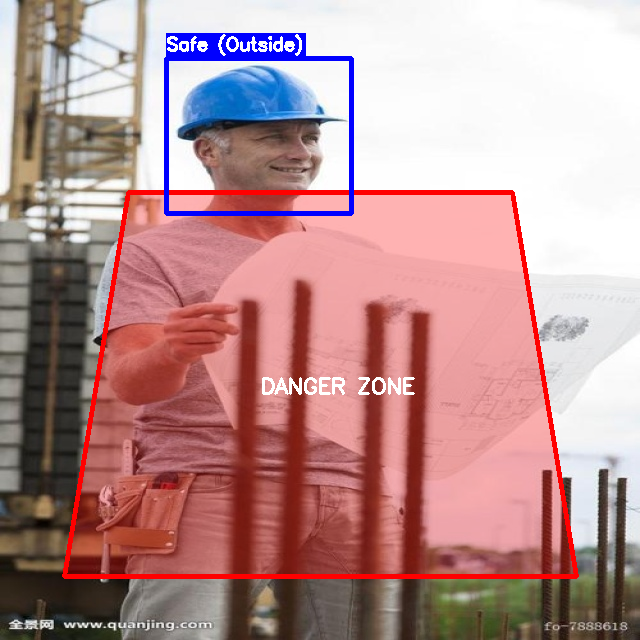


📸 분석 결과: bPartB_01783.jpg


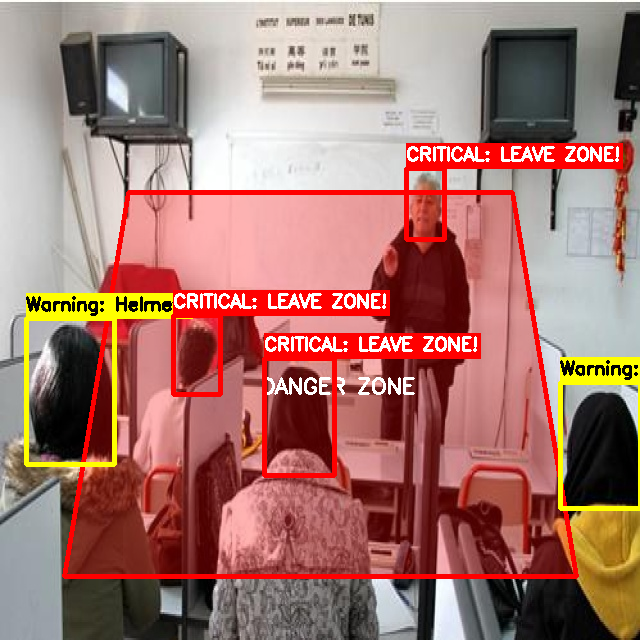


📸 분석 결과: bPartA_01756.jpg


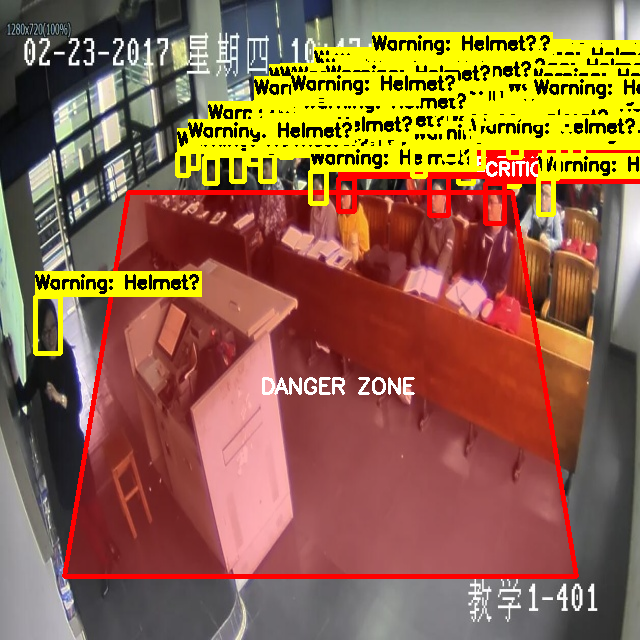

In [ ]:
# ==================================================================================
# 6. 추론 및 시각화 (Inference and Visualization)
# ==================================================================================
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import glob
import os

print(">> [6. Inference] 스마트 안전 모니터링 시스템 가동...")

# 1. 학습된 최적 모델 로드
try:
    best_model_path = '/content/runs/detect/safety_project_final/weights/best.pt'
    model = YOLO(best_model_path)
    print(f"✅ 모델 로드 성공: {os.path.basename(best_model_path)}")
except:
    print("❌ 모델을 찾을 수 없습니다. Part 1 학습을 먼저 완료해주세요.")
    model = None

# ----------------------------------------------------------------------------------
# 위험 구역(Danger Zone) 기반 4색 안전 판별 로직
# ----------------------------------------------------------------------------------
def draw_danger_zone(img, points):
    """이미지에 반투명한 위험 구역(Red Zone)을 시각화합니다."""
    overlay = img.copy()
    cv2.fillPoly(overlay, [points], (0, 0, 255)) # 빨간색 영역
    alpha = 0.3 # 투명도
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
    cv2.polylines(img, [points], True, (0, 0, 255), 3) # 테두리

    # 구역 이름 표시
    m = cv2.moments(points)
    if m["m00"] != 0:
        cx, cy = int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])
        cv2.putText(img, "DANGER ZONE", (cx - 60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

def is_in_zone(box, zone_points):
    """작업자가 위험 구역 내부에 있는지 판별합니다 (Point inside Polygon)."""
    x1, y1, x2, y2 = box
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2 # 작업자의 중심점
    return cv2.pointPolygonTest(zone_points, (cx, cy), False) >= 0

def run_safety_analysis(model, image_path):
    img = cv2.imread(image_path)
    if img is None: return
    h, w = img.shape[:2]

    # 1. 위험 구역 정의 (가상 시나리오: 화면 중앙 하단이 위험 구역)
    zone_pts = np.array([
        [int(w*0.2), int(h*0.3)], [int(w*0.8), int(h*0.3)],
        [int(w*0.9), int(h*0.9)], [int(w*0.1), int(h*0.9)]
    ], np.int32)
    draw_danger_zone(img, zone_pts)

    # 2. 모델 추론 (Confidence 0.25)
    results = model.predict(image_path, conf=0.25, verbose=False)
    if not results: return

    # 3. 객체 분석 및 상태 판정
    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id].lower()
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)

        # 'Helmet'(안전) 또는 'Head'(위험) 클래스만 분석 대상
        has_helmet = 'helmet' in cls_name
        is_head = 'head' in cls_name

        if not (has_helmet or is_head): continue

        # 위치 확인: 구역 내부인가?
        in_zone = is_in_zone(xyxy, zone_pts)

        # --- [핵심] 4단계 색상 코드 (Color Code) ---
        if in_zone:
            if has_helmet:
                color, label = (0, 255, 0), "Authorized (In Zone)"  # 🟢 구역 내 승인됨
            else:
                color, label = (0, 0, 255), "CRITICAL: LEAVE ZONE!" # 🔴 구역 내 헬멧 미착용
        else:
            if has_helmet:
                color = (255, 0, 0) # 파란색 (OpenCV는 BGR)
                label = "Safe (Outside)"                            # 🔵 구역 외 안전
            else:
                color, label = (0, 255, 255), "Warning: Helmet?"    # 🟡 구역 외 주의

        # 시각화
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img, (x1, y1 - 25), (x1 + text_w, y1), color, -1)
        txt_color = (0, 0, 0) if color in [(0, 255, 255), (0, 255, 0)] else (255, 255, 255)
        cv2.putText(img, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, txt_color, 2)

    print(f"\n📸 분석 결과: {os.path.basename(image_path)}")
    cv2_imshow(img)

# 테스트 실행 (검증 데이터셋에서 랜덤 샘플링)
import random
dataset_path = '/kaggle/input/hardhat-vest-dataset-v3'
test_images = glob.glob(os.path.join(dataset_path, '**', 'images', '**', '*.jpg'), recursive=True)
# 다양한 케이스 확인을 위해 랜덤하게 3장 선택
sample_images = random.sample(test_images, 3) if test_images else []

if model and sample_images:
    for img_path in sample_images:
        run_safety_analysis(model, img_path)
else:
    print("⚠️ 테스트 이미지를 찾을 수 없습니다.")

In [ ]:
# ==================================================================================
# 7. 모델 저장 및 내보내기 (Export)
# ==================================================================================
print(">> [7. Export] 모델 변환 및 저장...")

try:
    if os.path.exists(best_model_path):
        # ONNX 포맷으로 변환 (CPU 모드 권장)
        model.export(format='onnx', device='cpu')

        print("\n✅ 모델 내보내기 성공!")
        print(f"   📦 ONNX 파일 위치: {best_model_path.replace('.pt', '.onnx')}")
        print(f"   💾 PT 파일 위치:   {best_model_path}")
        print("\n[안내] 왼쪽 파일 탐색기에서 해당 경로를 찾아 우클릭 -> 다운로드 하시면 됩니다.")
    else:
        print("⚠️ 저장할 모델 파일(best.pt)이 없습니다.")
except Exception as e:
    print(f"❌ 내보내기 중 오류 발생: {e}")

print("\n🎉 모든 프로젝트 과정이 성공적으로 완료되었습니다!")